<a href="https://colab.research.google.com/github/sametgumus212/Python/blob/master/belirsizlik2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

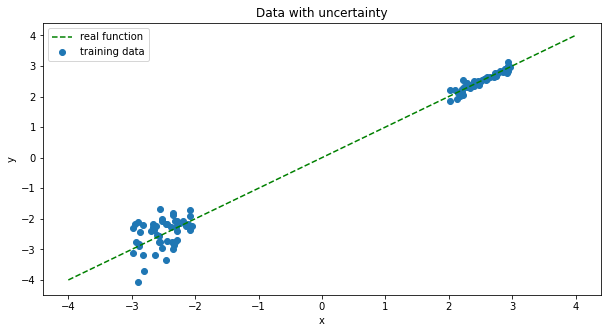

In [21]:
import numpy as np
import matplotlib.pyplot as plt

x_func = np.linspace(-4,4,100)
y_func = x_func

x_train = np.random.uniform(-3, -2, 50)
y_train = x_train + np.random.randn(*x_train.shape)*0.5

x_train = np.concatenate([x_train, np.random.uniform(2, 3, 50)])
y_train = np.concatenate([y_train, x_train[50:] + np.random.randn(*x_train[50:].shape)*0.1])
x_test = np.linspace(-10,10,100)

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(x_train, y_train, label='training data')
ax.plot(x_func, y_func, ls='--', label='real function', color='green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title('Data with uncertainty');

In [23]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2

# function for creating a fully connected neural network of any architecture
# the number of neurons in each layer is defined by layers_shape
# the droupout_proba indicates if dropout layers should be added
def architecture(layers_shape, input_dim, output_dim, dropout_proba, reg, act='relu', verbose=False):
    inputs = Input(shape=(input_dim,))
    hidden = Dense(layers_shape[0], activation=act,
                   kernel_regularizer=l2(reg))(inputs)
    for i in range(len(layers_shape)-1):
        if dropout_proba > 0:
          hidden = Dropout(dropout_proba)(hidden, training=True)
        hidden = Dense(layers_shape[i+1], activation=act, kernel_regularizer=l2(reg))(hidden)
    if dropout_proba > 0:
      hidden = Dropout(dropout_proba)(hidden, training=True)
    outputs = Dense(output_dim, kernel_regularizer=l2(reg))(hidden) 
    model = Model(inputs, outputs)
    if verbose:
      model.summary()
    return model
  
model_without_dropout = architecture(layers_shape=[5,10,20,10,5], input_dim= 1, output_dim=1, 
                                     dropout_proba=0, reg=0, act='relu', verbose=1)

model_with_dropout = architecture(layers_shape=[5,10,20,10,5], input_dim= 1, output_dim=1, 
                                  dropout_proba=0.05, reg=0.00475, act='relu', verbose=1)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_60 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_61 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_62 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_63 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_64 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 6  

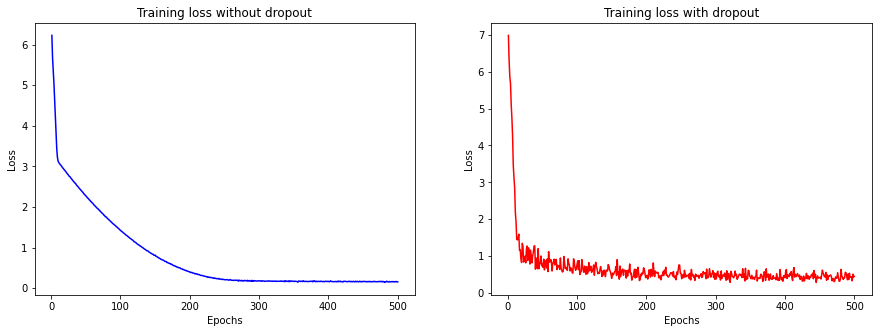

In [24]:
# training the network without dropout
model_without_dropout.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_without_dropout = model_without_dropout.fit(x_train, y_train, batch_size=10, 
                                                    epochs=500, shuffle=True, verbose=0)

# training the network with dropout
model_with_dropout.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_with_dropout = model_with_dropout.fit(x_train, y_train, batch_size=10, 
                                              epochs=500, shuffle=True, verbose=0)

# training performance
epochs = range(1, len(history_without_dropout.history['loss']) + 1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(epochs, history_without_dropout.history['loss'], 'b')
ax[0].set_title('Training loss without dropout')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].plot(epochs, history_with_dropout.history['loss'], 'r')
ax[1].set_title('Training loss with dropout')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss');

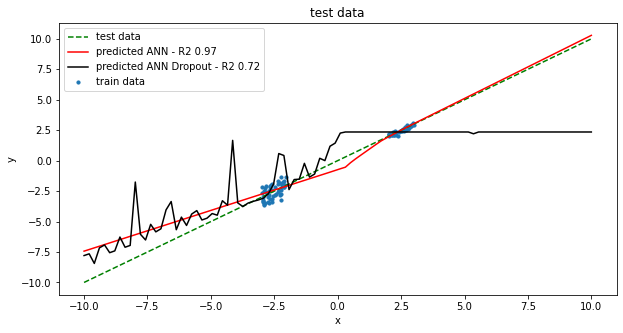

In [13]:
import sklearn
from sklearn.metrics import r2_score
# prediction
y_pred_without_dropout = model_without_dropout.predict(x_test)
y_pred_with_dropout = model_with_dropout.predict(x_test)

# plotting
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(x_train, y_train, s=10, label='train data')
ax.plot(x_test, x_test, ls='--', label='test data', color='green')
ax.plot(x_test, y_pred_without_dropout, label='predicted ANN - R2 {:.2f}'.format(r2_score(x_test, y_pred_without_dropout)), color='red')
ax.plot(x_test, y_pred_with_dropout, label='predicted ANN Dropout - R2 {:.2f}'.format(r2_score(x_test, y_pred_with_dropout)), color='black')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
ax.set_title('test data');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()


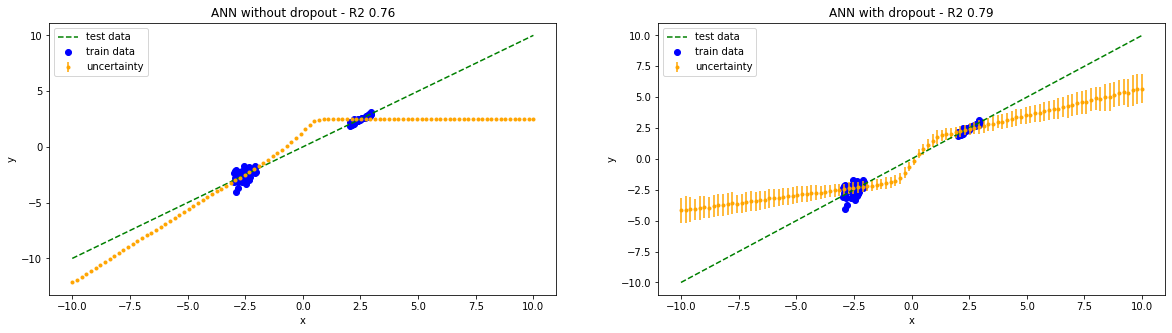

In [39]:
def plot_epistemic_uncertainty(model, ax, title, 
                     x_train=x_train, y_train=y_train, 
                     x_test=np.linspace(-10,10,100), y_test=np.linspace(-10,10,100),
                     T=500):
  predictions = []
  for _ in range(T):
      predictions += [model.predict(x_test,verbose=0)]    
  mean, std = np.mean(np.array(predictions), axis=0), np.std(np.array(predictions), axis=0)
  ax.plot(x_test, y_test, ls='--', color='green', label='test data')
  ax.scatter(x_train, y_train, color='blue', label='train data')
  ax.errorbar(x_test, mean, yerr=std, fmt='.', color='orange', label='uncertainty')
  ax.set_title('{} - R2 {:.2f}'.format(title, r2_score(y_test, mean)))
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.legend();
  
  
  
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_epistemic_uncertainty(model_without_dropout, ax=ax[0], title='ANN without dropout')
plot_epistemic_uncertainty(model_with_dropout, ax=ax[1], title='ANN with dropout')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()


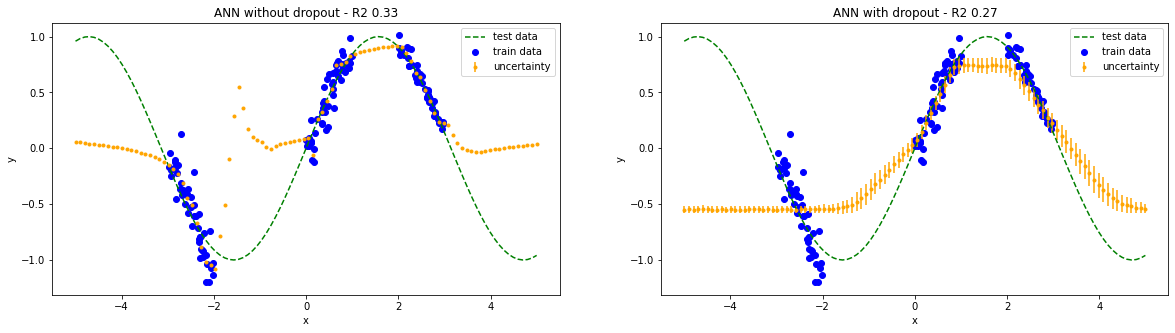

In [15]:
# generate synthetic polynomial data
x_func_poly = np.linspace(-5,5,100)
y_func_poly = lambda x: np.sin(x) 
x_train_poly = np.random.uniform(-3, -2, 50)
y_train_poly = y_func_poly(x_train_poly) + np.random.normal(scale=.2, size=x_train_poly.shape)
x_train_poly = np.concatenate([x_train_poly, np.random.uniform(0, 1, 50)])
y_train_poly = np.concatenate([y_train_poly, y_func_poly(x_train_poly[50:])+np.random.normal(scale=.1, size=x_train_poly[50:].shape)])
x_train_poly = np.concatenate([x_train_poly, np.random.uniform(2, 3, 50)])
y_train_poly = np.concatenate([y_train_poly, y_func_poly(x_train_poly[100:])+np.random.normal(scale=.05, size=x_train_poly[100:].shape)])
x_test_poly = np.linspace(-5,5,100)
y_test_poly = y_func_poly(x_test_poly)

# creating networks
model_poly_without_dropout = architecture(layers_shape=[50,100,200,100,50], input_dim= 1, output_dim=1, 
                               dropout_proba=0, reg=0, act='relu', verbose=0)
model_poly_with_dropout = architecture(layers_shape=[50,100,200,100,50], input_dim= 1, output_dim=1, 
                               dropout_proba=0.05, reg=0.00475, act='relu', verbose=0)

# training the networks
model_poly_without_dropout.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model_poly_without_dropout.fit(x_train_poly, y_train_poly, batch_size=10, epochs=2000, shuffle=True, verbose=0)
model_poly_with_dropout.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model_poly_with_dropout.fit(x_train_poly, y_train_poly, batch_size=10, epochs=2000, shuffle=True, verbose=0)

# plotting epistemic uncertainty
fig, ax = plt.subplots(1,2,figsize=(20,5))
plot_epistemic_uncertainty(model_poly_without_dropout, ax=ax[0], title='ANN without dropout', x_train=x_train_poly, y_train=y_train_poly, x_test=x_test_poly, y_test=y_test_poly)
plot_epistemic_uncertainty(model_poly_with_dropout, ax=ax[1], title='ANN with dropout', x_train=x_train_poly, y_train=y_train_poly, x_test=x_test_poly, y_test=y_test_poly)


In [16]:

from tensorflow.keras import backend as K
import tensorflow as tf

# aleatoric loss function
def aleatoric_loss(y_true, y_pred):
    N = y_true.shape[0]
    se = K.pow((y_true[:,0]-y_pred[:,0]),2)
    inv_std = K.exp(-y_pred[:,1])
    mse = K.mean(inv_std*se)
    reg = K.mean(y_pred[:,1])
    return 0.5*(mse + reg)

In [32]:

# model with support for aleatoric uncertainty
# note output dimension is 2: y and std
model_with_dropout_aleatoric = architecture(layers_shape=[5,10,20,10,5], 
                                            input_dim= 1, output_dim=2, 
                                            dropout_proba=0, reg=0, 
                                            act='relu', verbose=1)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_72 (Dense)             (None, 5)                 10        
_________________________________________________________________
dense_73 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_74 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_75 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_76 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_77 (Dense)             (None, 2)                 12 

In [35]:
model_with_dropout_aleatoric.compile(optimizer='rmsprop', 
                                     loss=aleatoric_loss, metrics=['mae'])

In [ ]:

# reshape tensors to support two outputs
x_train_reshaped = x_train.reshape(x_train.shape[0], 1)
y_train_reshaped = np.vstack([y_train, np.zeros(y_train.shape)]).T

# # training the network
# model_without_dropout_aleatoric.compile(optimizer='rmsprop', 
#                                      loss=aleatoric_loss, metrics=['mae'])
model_with_dropout_aleatoric.fit(x_train_reshaped, y_train_reshaped, 
                                 batch_size=10, epochs=1000, shuffle=True, verbose=1)

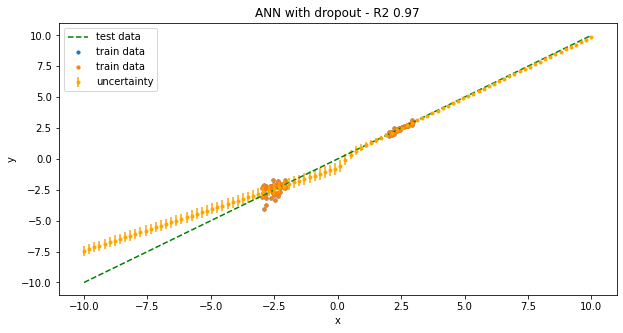

In [38]:
# function to predict on the test dataset, and the epistemic uncertainty
def predictor(model, 
              X_test, T=100):
    probs = []
    for _ in range(T):
        probs += [model.predict(X_test,verbose=0)]
    return probs
  
# function to plot uncertainty
def plot_aleatoric_uncertainty(model, ax, title, 
                     x_train=x_train, y_train=y_train, 
                     x_test=np.linspace(-10,10,100), y_test=np.linspace(-10,10,100),
                     T=1):
  p = np.array(predictor(model, x_test, T=1))
  mean, epistemic_std = np.mean(p[:,:,0], axis=0), np.std(p[:,:,0], axis=0)
  aleatoric_std = np.exp(0.5*np.mean(p[:,:,1], axis=0))
  ax.scatter(x_train, y_train[:,0], s=10, label='train data')
  ax.plot(x_test, x_test, ls='--', label='test data', color='green')
  ax.errorbar(x_test, mean, yerr=aleatoric_std, fmt='.', label='uncertainty', color='orange')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_title('{} - R2 {:.2f}'.format(title, r2_score(y_test, mean)))
  ax.legend()

# plot aleatoric uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(x_train_reshaped, y_train_reshaped[:,0], s=10, label='train data')
plot_aleatoric_uncertainty(model_with_dropout_aleatoric, ax, 'ANN with dropout', 
                           x_train_reshaped, y_train_reshaped)